In [33]:
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Chroma
from langchain import hub
from chromadb.utils import embedding_functions

In [34]:
embedding_function = OpenAIEmbeddings()

docs = [
    Document(
        page_content="Bella Vista is owned by Antonio Rossi, a renowned chef with over 20 years of experience in the culinary industry. He started Bella Vista to bring authentic Italian flavors to the community.",
        metadata={"source": "owner.txt"},
    ),
    Document(
        page_content="Bella Vista offers a range of dishes with prices that cater to various budgets. Appetizers start at $8, main courses range from $15 to $35, and desserts are priced between $6 and $12.",
        metadata={"source": "dishes.txt"},
    ),
    Document(
        page_content="Bella Vista is open from Monday to Sunday. Weekday hours are 11:00 AM to 10:00 PM, while weekend hours are extended from 11:00 AM to 11:00 PM.",
        metadata={"source": "restaurant_info.txt"},
    ),
    Document(
        page_content="Bella Vista offers a variety of menus including a lunch menu, dinner menu, and a special weekend brunch menu. The lunch menu features light Italian fare, the dinner menu offers a more extensive selection of traditional and contemporary dishes, and the brunch menu includes both classic breakfast items and Italian specialties.",
        metadata={"source": "restaurant_info.txt"},
    ),
]

db = Chroma.from_documents(docs, embedding_function)
# retriever = db.as_retriever()
retriever = db.as_retriever(search_kwargs={"k": 2})

In [35]:
prompt = hub.pull("rlm/rag-prompt")

llm = ChatOpenAI(model="gpt-4o-mini")

/home/safeer/Documents/devops/agents/LangGraph-Agents/.venv-agent/lib/python3.12/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [36]:
from typing import Annotated, TypedDict
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langchain.schema import Document
from pydantic import BaseModel, Field

from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate


In [37]:
class AgentState (TypedDict):
    """State of the agent."""
    documents: list[Document]
    messages: list[BaseMessage]
    topic: str 

In [ ]:
def on_off_topic_router (state : AgentState):
    """Router function to determine if the topic is on or off."""
    if state["topic"] == "on_topic":
        return "rag_retriver"
    else:
        return "off_topic_response"

In [39]:
class question_type(BaseModel):
    """Type of question."""
    question: str = Field(description="Question is about restaurant? If yes -> 'Yes' if not -> 'No'")

def classify_question( state :AgentState):

    question = state["messages"][-1].content

    print (f"Classifying question: {state}")

    system_prompt = """You are a classifier that determines whether a user's question is about one of the following topics:

    1. Information about the owner of Bella Vista, which is Antonio Rossi.
    2. Prices of dishes at Bella Vista (restaurant).
    3. Opening hours of Bella Vista (restaurant).

    If the question IS about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'. Remember, ONLY YES or NO, nothing else in the reponse!
    """

    grade_question = ChatPromptTemplate.from_messages(
        [
            SystemMessage(content=system_prompt),
            HumanMessage(content="{question}"),
        ]
    )

    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)
    llm_wiht_structure = llm.with_structured_output(question_type)
    prompt = grade_question.format_prompt(question=question)

    resp = llm_wiht_structure.invoke(prompt.to_messages())

    print(f"Response from classification: {resp}")
    if resp.question == "Yes":
        print("Question is about the restaurant.")
        state["topic"] = "on_topic"

    else:
        print("Question is not about the restaurant.")
        state["topic"] = "off_topic"

    return state 

def retriever_from_db (state :AgentState):
    """Retrieve relevant documents from the database based on the question."""
    question = state["messages"][-1].content
    print(f"Retrieving documents for question: {question}")
    retrieved_docs = retriever.invoke(question)
    state["documents"] = retrieved_docs # ["documents"]
    print(f"Retrieved documents: {state['documents']}")
    return state

def off_topic_response(state: AgentState):
    """Handle off-topic questions."""
    print("Handling off-topic question.")
    # state["messages"].append(AIMessage(content="This question is not related to the restaurant."))
    state["documents"] = "This question is not related to the restaurant."
    
    return state

def generate_answer(state: AgentState):
    """Generate an answer based on the retrieved documents."""
    print("Generating answer based on retrieved documents.")
    # if not state["documents"]:
    #     state["messages"].append(AIMessage(content="No relevant information found."))
    #     return state



    context = "\n".join([doc.page_content for doc in state["documents"]])
    question = state["messages"][-1].content

    answer_prompt = ChatPromptTemplate.from_messages(
        [
            SystemMessage(content="You are a helpful assistant that answers questions based on the provided context."),
            HumanMessage(content=question),
            AIMessage(content=context),
        ]
    )

    formatted_prompt = answer_prompt.format_prompt(question=question, context=context)
    llm_response = llm.invoke(formatted_prompt.to_messages())

    # state["messages"].append(AIMessage(content=llm_response.content))
    state["messages"].append( llm_response )
    
    return state

retriever_from_db (
    {
        "messages":[HumanMessage(content="What is the name of the owner of Bella Vista resturant?")],
    }  
)


Retrieving documents for question: What is the name of the owner of Bella Vista resturant?
Retrieved documents: [Document(metadata={'source': 'owner.txt'}, page_content='Bella Vista is owned by Antonio Rossi, a renowned chef with over 20 years of experience in the culinary industry. He started Bella Vista to bring authentic Italian flavors to the community.'), Document(metadata={'source': 'owner.txt'}, page_content='Bella Vista is owned by Antonio Rossi, a renowned chef with over 20 years of experience in the culinary industry. He started Bella Vista to bring authentic Italian flavors to the community.')]


{'messages': [HumanMessage(content='What is the name of the owner of Bella Vista resturant?', additional_kwargs={}, response_metadata={})],
 'documents': [Document(metadata={'source': 'owner.txt'}, page_content='Bella Vista is owned by Antonio Rossi, a renowned chef with over 20 years of experience in the culinary industry. He started Bella Vista to bring authentic Italian flavors to the community.'),
  Document(metadata={'source': 'owner.txt'}, page_content='Bella Vista is owned by Antonio Rossi, a renowned chef with over 20 years of experience in the culinary industry. He started Bella Vista to bring authentic Italian flavors to the community.')]}

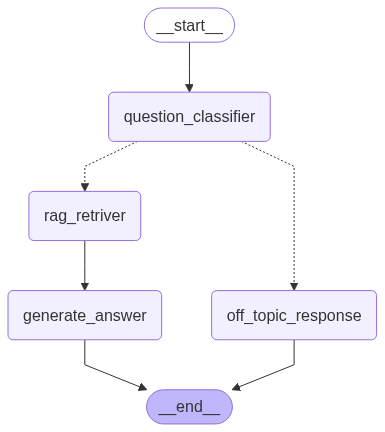

In [40]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph (AgentState)

graph.add_node( "question_classifier", classify_question)
graph.add_node("rag_retriver", retriever_from_db)
graph.add_node("off_topic_response", off_topic_response)
graph.add_node("generate_answer", generate_answer)

graph.add_edge(START, "question_classifier")
# graph.add_edge("question_classifier", "rag_retriver")
# graph.add_edge("question_classifier", "off_topic_response")
graph.add_edge("rag_retriver", "generate_answer")
# graph.add_edge("off_topic_response", "generate_answer")
graph.add_edge("generate_answer", END)
graph.add_edge("off_topic_response", END)

graph.add_conditional_edges(
    "question_classifier",
    on_off_topic_router,
    {
        "rag_retriver": "rag_retriver",
        "off_topic_response": "off_topic_response",
    }
)

graph.add_edge("question_classifier", END)

run = graph.compile()

run

In [41]:
run.invoke(
    {
        "messages":[HumanMessage(content="What is the name of the owner of Bella Vista?")],
    }   
)

Classifying question: {'messages': [HumanMessage(content='What is the name of the owner of Bella Vista?', additional_kwargs={}, response_metadata={})]}
Response from classification: question='No'
Question is not about the restaurant.
Retrieving documents for question: What is the name of the owner of Bella Vista?
Retrieved documents: [Document(metadata={'source': 'owner.txt'}, page_content='Bella Vista is owned by Antonio Rossi, a renowned chef with over 20 years of experience in the culinary industry. He started Bella Vista to bring authentic Italian flavors to the community.'), Document(metadata={'source': 'owner.txt'}, page_content='Bella Vista is owned by Antonio Rossi, a renowned chef with over 20 years of experience in the culinary industry. He started Bella Vista to bring authentic Italian flavors to the community.')]
Generating answer based on retrieved documents.


{'documents': [Document(metadata={'source': 'owner.txt'}, page_content='Bella Vista is owned by Antonio Rossi, a renowned chef with over 20 years of experience in the culinary industry. He started Bella Vista to bring authentic Italian flavors to the community.'),
  Document(metadata={'source': 'owner.txt'}, page_content='Bella Vista is owned by Antonio Rossi, a renowned chef with over 20 years of experience in the culinary industry. He started Bella Vista to bring authentic Italian flavors to the community.')],
 'messages': [HumanMessage(content='What is the name of the owner of Bella Vista?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The owner of Bella Vista is Antonio Rossi, a renowned chef with over 20 years of experience in the culinary industry. He established Bella Vista to offer authentic Italian flavors to the community.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 112, 'total_tokens

In [1]:
from langchain_openai import ChatOpenAI

In [2]:
llm = ChatOpenAI(
    base_url="https://openrouter.ai/api/v1",
    model="deepseek/deepseek-r1:free",
    api_key="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",
    temperature=1.0,
    )

In [3]:
llm.invoke("What is the name of the owner of Bella Vista?")

AIMessage(content='The name "Bella Vista" is used by many businesses, properties, and locations worldwide, so without additional context (e.g., location, type of establishment), it’s difficult to identify the specific owner. For example:\n\n- **Bella Vista, Arkansas** is a city and does not have a single "owner."\n- **Bella Vista** could refer to a hotel, restaurant, winery, or private estate, each with different ownership.\n\nIf you provide more details (e.g., country, industry, or notable features), I can help narrow it down!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 723, 'prompt_tokens': 17, 'total_tokens': 740, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'deepseek/deepseek-r1:free', 'system_fingerprint': None, 'id': 'gen-1754757998-8TOjGlXQ0kb4xGlNN5ME', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--de79cddd-905f-4d31-8307-f939021e950b-0', usage_metadata={'input_to